# Проверка работы модели

In [73]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from datasets import load_dataset
from evaluate import evaluator

import seaborn as sns
import matplotlib.pyplot as plt
import evaluate

%matplotlib inline
sns.set(style='whitegrid')

In [80]:
# Загрузка токенизатора и модели
tokenizer = AutoTokenizer.from_pretrained('roberta-base')
model = AutoModelForSequenceClassification.from_pretrained('RoBERTa/RoBERTA_best_model')

## Применение модели

In [109]:
# Задание pipeline
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0)

In [65]:
# Пример метки bug
classifier("I has a bug!", top_k=4)

[{'label': 'bug', 'score': 0.7495560050010681},
 {'label': 'question', 'score': 0.22529597580432892},
 {'label': 'enhancement', 'score': 0.014066243544220924},
 {'label': 'documentation', 'score': 0.01108174491673708}]

In [66]:
# Пример метки enhancement
classifier("Suggest feature", top_k=4)

[{'label': 'enhancement', 'score': 0.9391063451766968},
 {'label': 'documentation', 'score': 0.04345748573541641},
 {'label': 'question', 'score': 0.014191466383635998},
 {'label': 'bug', 'score': 0.003244661493226886}]

In [67]:
# Пример метки question
classifier("Does this app support python?", top_k=4)

[{'label': 'question', 'score': 0.9074325561523438},
 {'label': 'enhancement', 'score': 0.05024679750204086},
 {'label': 'documentation', 'score': 0.0325617752969265},
 {'label': 'bug', 'score': 0.00975882913917303}]

In [68]:
# Пример метки documentation
classifier("Documentation missing", top_k=4)

[{'label': 'documentation', 'score': 0.9842588901519775},
 {'label': 'enhancement', 'score': 0.006323229055851698},
 {'label': 'bug', 'score': 0.005313330329954624},
 {'label': 'question', 'score': 0.0041045453399419785}]

## Оценка качества модели

In [ ]:
test_dataset = load_dataset("csv", data_files="issue_data_encoded.csv", data_dir="data/preprocessed/")
test_dataset = test_dataset['train'].shuffle(seed=7).select(range(6500))

In [189]:
# Загрузка оценщика
task_evaluator = evaluator("text-classification")

In [190]:
task_evaluator.compute(
    model_or_pipeline=classifier,
    data=test_dataset,
    label_column='labels',
    label_mapping={'bug' : 0, 'enhancement' : 1, 'documentation' : 2, 'question' : 3},
)

{'accuracy': 0.8116923076923077,
 'total_time_in_seconds': 137.59188559999984,
 'samples_per_second': 47.24115794805277,
 'latency_in_seconds': 0.021167982399999972}

In [191]:
# Загрузка F-меры
metric = evaluate.load("f1")

In [192]:
def label_to_num(label):
    if label == 'bug':
        number = 0
    elif label == 'enhancement':
        number = 1
    elif label == 'documentation':
        number = 2
    else:
        number = 3
    return number

In [193]:
# Получение предсказанных меток
pred = classifier(test_dataset['text'], padding=True, truncation=True)
pred_list = [pred[i]['label'] for i in range(0, len(pred))]

In [194]:
pred_list = list(map(label_to_num, pred_list))

In [195]:
# Преобразование исходных меток
ref = test_dataset['labels']

In [199]:
# Расчёт f-меры
f1 = metric.compute(predictions=pred_list, references=ref, average=None)

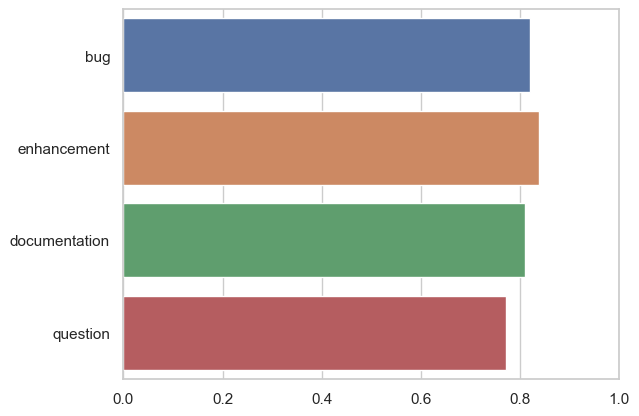

In [200]:
# График F-меры по классам
_, ax = plt.subplots()
sns.barplot(x=f1['f1'], y=['bug', 'enhancement', 'documentation', 'question'])
ax.set_xlim(0, 1)
plt.show()